In [2]:
import sqlite3
from requests.exceptions import Timeout, ConnectionError
import time
from time import sleep
import pandas as pd
import pyodbc

In [3]:
# Setting the connection strings
server = 'tcp:isye-6420-project.database.windows.net,1433' 
database = 'topic_modelling' 
username = 'project_administrator' 
password = 'isye_6420_admin' 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
#SQLite cursor
c = conn.cursor()

In [4]:
# Method to read the twitter messages into the pandas dataframe
def read_sql():
    train_data =  pd.read_sql_query('select [tweet_text], [Political_party] from tweets_raw', conn) 
    return(train_data)

In [5]:
# Step 1 : Data Loading 
    
# Executing method to read twitter messages into dataframe
#train_data = read_sql()
    

In [6]:
#(train_data.to_pickle('train_data.p'))

In [7]:
train_data = pd.read_pickle('train_data.p')

In [8]:
# Step 2: Data Cleaning 

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# print the train_data column names 
print(train_data.columns)

# Load the regular expression library
import re

#  1. Remove URLs
train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

# 2. Remove punctuation
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('[,\.!?@]', '', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'']', '', x))

# 3. Convert the titles to lowercase
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: x.lower())

# 4. Removing the word 'amp' 
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('amp', '', x))

# 5. #remove times pm
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('\d+pm', '', x))

# 6. Additional claeaning 
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("it's",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("n't",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("'",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("-",'', x))


Index(['tweet_text', 'Political_party'], dtype='object')


In [9]:
# 7. Removing Stopwords 

import nltk 
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english','spanish'))
def remove(text,wordset=STOPWORDS):
    splits = text.split()
    result=[]
    for split in splits:
        if split not in wordset:
            result.append(split)
    return (" ".join(result))        

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x))

print(train_data['tweet_text'].head(1000))

0                                                   love
1      2016 single question climate change presidenti...
2      without doubt joebiden commanderinchief countr...
3      leader among next generation democrats committ...
4      moving tribute mayor keishabottoms dear friend...
                             ...                        
995                     hope guys enjoyed interntakeover
996    bonus rounddd 🚨🚨🚨 chooses statues statuary hal...
997                  many statues national statuary hall
998           designed u capitol sorry options long poll
999                 congress first meet capitol building
Name: tweet_text, Length: 1000, dtype: object


In [10]:
#  8. To retain only the Nouns and Adjectives in every tweet 

import spacy

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    doc = nlp(texts) 
    texts_out = " ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out     

# Do lemmatization keeping only noun, adj parts of speech (POS)
train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: lemmatization(x, allowed_postags=['NOUN', 'ADJ']))

print(train_data['tweet_text'])

0                                                      love
1         single question climate change presidential de...
2              doubt commanderinchief country demconvention
3         leader next generation service future first st...
4             mayor dear way vote text vote plan vote today
                                ...                        
101794                      company manufacturing job visit
101795    freedom time way life economy american dream c...
101796     hearing clear policy justice scotus constitution
101797    abortion many people year covid19 country prev...
101798                                              problem
Name: tweet_text, Length: 101799, dtype: object


In [11]:
# 9. To eliminate additional words 

eliminate_words = ['today', 'year', 'people', 'time', 'great', 'day', 'morning', 'evening', 'community', 'important',
                   'many', 'family', 'sure', 'visit', 'https', 'new', 'work', 'proud', 'thank', 'good', 'way', 'help',
                   'need', 'member', 'week', 'nation', 'support', 'last', 'effort', 'yesterday', 'news', 'watch', 'state',
                   'safe', 'happy', 'birthday', 'colleague', 'tonight', 'part', 'much', 'now', 'country', 'leader', 'program',
                   'congratulation', 'conversation', 'fact', 'government', 'house', 'right', 'tomorrow', 'question', 'long',
                   'public', 'big', 'million', 'benefit', 'information', 'report' , 'friend', 'life', 'bad' , 'word', 'true',
                   'woman', 'man', 'local', 'action', 'resource', 'high','school', 'opportunity', 'town', 'event', 'meeting',
                   'tune', 'pm', 'student', 'live', 'discussion', 'discuss', 'child', 'world', 'policy', 'condition', 'hand',  
                   'office', 'place', 'resident', 'site' , 'concern', 'city', 'free', 'congressional', 'WORKER', 'history',
                   'M', 'P', 'wonderful', 'team', 'update', 'facebook', 'minute', 'op', 'water', 'food', 'hour', 'pm', 
                   'thing', 'art', 'folk', 'annual', 'prayer', 'thought', 'heart', 'statement', 'story', 'special', 'pre',
                   'honor', 'young', 'neighbor', 'night', 'district', 'late', 'moment', 'case', 'census', 'person', 'voice', 
                   'wrong',  'share', 'victory', 'grateful', 'century', 'kid', 'difficult', 'afternoon', 'love', 'youth', 
                   'fellow', 'mother',  'comment', 'official', 'month', 'worker', 'p m', ' m ', 'crisis', 'issue']

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x, wordset=eliminate_words ))

In [12]:
extra_words = {'today','thank','11','wa','con','por','del','los','que','para','en','el','la','de','sure','know','make','going','your',
'about','they','ve','we','re','ing','im','proud','ago','act','tonight','tune','live','morning','listen','join','discuss',
'forward','great','will','see','must','tomorrow','day','one','host','hall','god','bless','about','happy','birthday',
'birth','fireside','chat','celebrating','christmas','roshhashanah','graduation','high','celebration','yom kippur','time',
'year','new','easter','art','competition','guest','hosting','seanhannity','facebook','ill','wolfblitzer','joining',
'fridayswithfrank','town','hold','sunday','night','thanks','watching','point','good','nightclub','camdencountynj',
'weekly','update','page','yom','kippur','congratulations','congratulation','eaglej','scout','weeks','week','todays',
'daily','yesterday','youll','cnnsitrom','shortly','minute','happening','soon','foxnews','900p','ne02','gobierno',
'estados','unidos','visite','nuestra','pagina ','federales','estados','agencias','kbtxnews','totally','agree','wtaw1620',
'icymi','segment','coming','soon','et','praying','speedy','frequently','asked','question','thought','share','noon','newsletter',
'clicking','exactly','right','1000p','1100p','wishing','algal','bloom','app','receive','245th','244th','start','hour',
'olg','youve','loudobbs','foxbusiness','free','feel','passionate','west','palm','sign','link','va','inside','ill',
'foxandfriend','valley','watch','informacion','espanol','acerca','sus','link','servicios','pagina','ill','foxandfriend',
'valley','watch','informacion','espanol','acerca','kwtx','ne03', 'quid','foxnewsnight','pagina','espanol','quid','passover',
'simonradio1776','whoradio', '800wvhu','ill3'}

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x,extra_words))


In [13]:
# 10. Replace with Synomyms 

def replace_synonyms(text):
    splits = text.split()
    result=[]
    for split in splits:
        if split in synonyms:
            result.append(synonyms[split])
        else:
            result.append(split)
    return (" ".join(result))        

#replace synonyms
synonyms = {'donald':'trump','realdonaldtrump':'trump','joebiden':'biden'}
#synonyms = {'donald':'trump','realdonaldtrump':'trump','joebiden':'biden'}
#synonyms = {'paycheck protection':'paycheck protection program','protection program':'paycheck protection program'}
#synonyms = {'admin':'administration'}
#synonyms = {'realdonaldtrump':'trump'}
#synonyms = {'joebiden':'biden'}
train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: replace_synonyms(x))

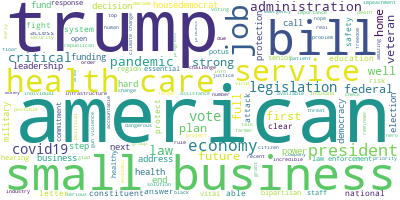

In [14]:
# Step 3: Exploratory Analysis 

# Import the wordcloud library
import wordcloud
from wordcloud import WordCloud

# Spliting across party Lines 
#train_data_dem = train_data.loc[train_data['Political_party'] == "Democratic Party"]
train_data_dem = train_data.loc[(train_data['Political_party'] == "Republican Party") | (train_data['Political_party'] == "Democratic Party") ]

#train_data_rep = train_data.loc[train_data['Political_party'] == "Republican Party"]

# Join the different processed tweets together.
long_string_dem = ','.join(list(train_data_dem['tweet_text'].values))
#long_string_rep = ','.join(list(train_data_rep['tweet_text'].values))

# Create a WordCloud object
wordcloud_dem = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')
#wordcloud_rep = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')

# Generate a word cloud
wordcloud_dem.generate(long_string_dem)
# Visualize the Democratic word cloud
wordcloud_dem.to_image()


In [15]:
# Step 4: Data Preparation before training Model 

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()




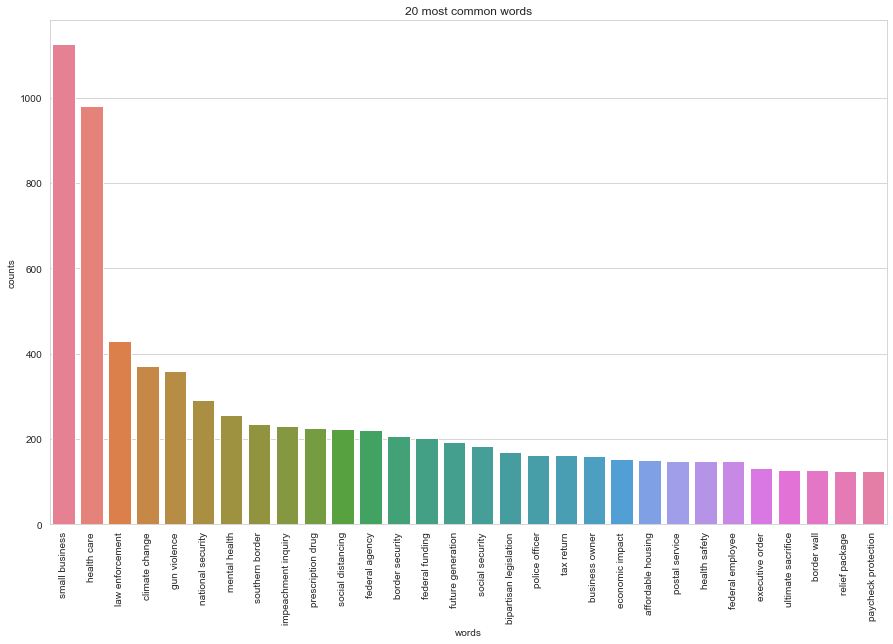

In [16]:
# 30_most_common_words in Democrats tweets
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=10)
hv.transform(train_data_dem["tweet_text"])   

from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer_dem = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english', max_features= 1000)
# Fit and transform the processed tweets
count_data_dem = count_vectorizer_dem.fit_transform(train_data_dem['tweet_text'])
# Visualise the 30 most common words
plot_30_most_common_words(count_data_dem, count_vectorizer_dem)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer_demo = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english')
#count_vectorizer_repub =TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english')

# Calculate DocTerm Matrices
count_data_demo = count_vectorizer_demo.fit_transform(train_data_dem['tweet_text'])
#count_data_repub = count_vectorizer_repub.fit_transform(train_data_rep['tweet_text'])

In [25]:
print(count_data_demo[0,:])

<99402x26355 sparse matrix of type '<class 'numpy.float64'>'
	with 560116 stored elements in Compressed Sparse Row format>

In [26]:
# Democratic Party 

from gensim import corpora
from sklearn.decomposition import TruncatedSVD as LSA


# Create Dictionary
text_dems=[[text for text in doc.split()] for doc in train_data_dem['tweet_text']]
dictionary_dems = corpora.Dictionary(text_dems)
corpus_dems= [dictionary_dems.doc2bow(text) for text in text_dems]



In [27]:
#Build manual tokenized topics
def TokenTopics(DocTerm, TopicAffinity,NumTerms=10):
    result=[]
    for i,topic in enumerate(TopicAffinity):
        result.append([DocTerm.get_feature_names()[i] for i in topic.argsort()[-NumTerms:]]) 
    return result

def CalculateCoherence(corpus1,dictionary1,text1,tt,coherence1='c_v'):
    cm=0
    if coherence1[0]=='u':
        cm = CoherenceModel(topics=tt, corpus=corpus1, dictionary=dictionary1, coherence=coherence1,processes=-1)    
    else: 
        cm = CoherenceModel(topics=tt, texts=text1, dictionary=dictionary1, coherence=coherence1,processes=-1)
    return cm.get_coherence()



In [28]:
print(np.isinf(count_data_demo.data).any())
print(np.isnan(count_data_demo.data).any())


False
False


In [22]:
#Try different topic sizes, parameters
from gensim.models.coherencemodel import CoherenceModel
coherence_dems = dict()

for a in range(5,30):
    
    print(a)
    
    LSA_demo = LSA(n_components=a, random_state=42, n_iter=100, algorithm='randomized')
    LSA_demo.fit_transform(count_data_demo)
    tt = TokenTopics(count_vectorizer_demo,LSA_demo.components_)
    
    label='p'+str(a)
    coherence_dems[label]=CalculateCoherence(corpus_dems,dictionary_dems,text_dems,tt,'c_v')
    
  

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [23]:
coherence_score = list(coherence_dems.values())
coherence_score

[0.28893162629887226,
 0.27303729817345695,
 0.279289508455291,
 0.2848244298521908,
 0.28907466993710906,
 0.28810409128135,
 0.2792241818262278,
 0.28995348172133123,
 0.28402110445863815,
 0.29041760773950526,
 0.3170177155889883,
 0.33743182182118914,
 0.34152832525458793,
 0.3341329896793585,
 0.3396639159474366,
 0.3340064738491916,
 0.3338817846992156,
 0.3255788816113647,
 0.3277340791657445,
 0.3242825441827381,
 0.33022810705715083,
 0.32517849979338015,
 0.3239182782319294,
 0.32301452281473475,
 0.3171318214907046]

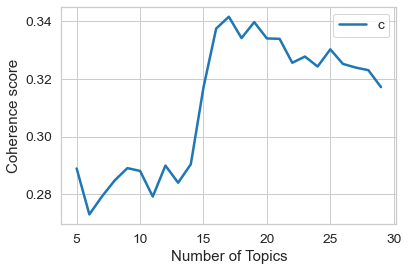

In [36]:
# Show graph
x = range(5,30)
plt.plot(x, coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Create the LSA Model with Optimal paramters obtained from above step for Democratic party 
 
#largest = max(coherence_score)
#a = coherence_score.index(largest) + 5
#print(a)
LSA_demo = LSA(n_components=17, random_state=42, n_iter=100, algorithm='randomized')
LSA_dem = LSA_demo.fit_transform(count_data_demo)



In [32]:
terms = count_vectorizer_demo.get_feature_names()
topic_dems = dict()

for i, comp in enumerate(LSA_demo.components_):
    print_topic = [] 
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    label = "topic_" + str(i)
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print_topic.append(t[0])
    print(print_topic)
    topic_dems[label] = print_topic[0] + '-' + print_topic[1] + '-' + print_topic[2]
    

Topic 0: 
['health', 'business', 'care', 'small', 'american', 'covid19', 'job', 'service', 'economy', 'federal']
Topic 1: 
['business', 'small', 'loan', 'relief', 'economy', 'owner', 'job', 'paycheck', 'ppp', 'employee']
Topic 2: 
['american', 'vote', 'job', 'impeachment', 'president', 'trump', 'law', 'election', 'service', 'economy']
Topic 3: 
['service', 'veteran', 'sacrifice', 'federal', 'brave', 'military', 'covid19', 'freedom', 'postal', 'critical']
Topic 4: 
['vote', 'impeachment', 'election', 'law', 'legislation', 'democracy', 'president', 'violence', 'small', 'ballot']
Topic 5: 
['american', 'service', 'business', 'small', 'veteran', 'care', 'health', 'impeachment', 'sacrifice', 'freedom']
Topic 6: 
['job', 'vote', 'economy', 'service', 'care', 'veteran', 'unemployment', 'wage', 'low', 'strong']
Topic 7: 
['covid19', 'vote', 'american', 'testing', 'relief', 'response', 'package', 'mask', 'virus', 'service']
Topic 8: 
['impeachment', 'president', 'trump', 'covid19', 'inquiry', '

In [33]:
topic_dems

{'topic_0': 'health-business-care',
 'topic_1': 'business-small-loan',
 'topic_2': 'american-vote-job',
 'topic_3': 'service-veteran-sacrifice',
 'topic_4': 'vote-impeachment-election',
 'topic_5': 'american-service-business',
 'topic_6': 'job-vote-economy',
 'topic_7': 'covid19-vote-american',
 'topic_8': 'impeachment-president-trump',
 'topic_9': 'federal-agency-funding',
 'topic_10': 'veteran-impeachment-federal',
 'topic_11': 'border-security-veteran',
 'topic_12': 'trump-veteran-election',
 'topic_13': 'border-security-impeachment',
 'topic_14': 'drug-prescription-cost',
 'topic_15': 'economy-strong-future',
 'topic_16': 'president-election-drug'}

In [34]:
pd.options.display.float_format = '{:,.16f}'.format
topic_encoded_df = pd.DataFrame(LSA_dem, columns = ["topic_0", "topic_1", "topic_2", "topic_3","topic_4","topic_5", "topic_6", "topic_7", "topic_8", "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14", "topic_15", "topic_16"])
topic_encoded_df["probable_Topic"] = topic_encoded_df.idxmax(axis=1)
topic_encoded_df["Topic_Probability"] = topic_encoded_df.max(axis=1)
topic_encoded_df["documents"] = train_data['tweet_text']
topic_encoded_df["probable_Topic"].replace(topic_dems, inplace=True)
display(topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]])

,documents,probable_Topic,Topic_Probability
0,,american-service-business,0.0000000000000125
1,single climate change presidential debate lett...,economy-strong-future,0.1029862545346144
2,doubt commanderinchief demconvention,border-security-veteran,0.0020393908695196
3,next generation service future first step well...,service-veteran-sacrifice,0.1947161252865554
4,mayor dear vote text vote plan vote,vote-impeachment-election,0.5051265256447991
...,...,...,...
99397,medicareforall run onesizefitsall health plan ...,job-vote-economy,0.2856164965997882
99398,low gas price obama republican focus productio...,economy-strong-future,0.1563373002257500
99399,job market employment optimism workforce unemp...,american-vote-job,0.0539918829548894
99400,dominance socialist green deal gopheat,covid19-vote-american,0.1463690391011187


In [35]:
democ_topic_model = topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]]

In [36]:
democ_topic_model = democ_topic_model.reset_index(drop=True)

In [37]:
democ_data  = pd.read_pickle('train_data.p')
democ_data = democ_data.loc[(democ_data['Political_party'] == "Republican Party") | (democ_data['Political_party'] == "Democratic Party") ]
democ_data = democ_data.reset_index(drop=True)

#democ_data =  pd.read_sql_query("select [tweet_text] from tweets_raw ", conn) 

In [38]:
democ_topic_model["documents"] = democ_data["tweet_text"].copy()
democ_topic_model

,documents,probable_Topic,Topic_Probability
0,Love it! https://t.co/NZh4aQp5Cc,american-service-business,0.0000000000000125
1,"In 2016, there wasn't a single question on cli...",economy-strong-future,0.1029862545346144
2,"Without a doubt, @JoeBiden is the Commander-in...",border-security-veteran,0.0020393908695196
3,A leader among the next generation of Democrat...,service-veteran-sacrifice,0.1947161252865554
4,A moving tribute from Mayor @KeishaBottoms for...,vote-impeachment-election,0.5051265256447991
...,...,...,...
99397,#GoodNews: companies continue to invest in SW ...,job-vote-economy,0.2856164965997882
99398,Freedom surrendered is rarely reclaimed. It’s ...,economy-strong-future,0.1563373002257500
99399,"#ConfirmACB Watching the hearing, it seems cle...",american-vote-job,0.0539918829548894
99400,Abortion kills more than 4x as many people per...,covid19-vote-american,0.1463690391011187


In [39]:
(democ_topic_model.to_pickle('topic_modelling_LSA_v4.p'))

In [1]:
LSA_demo.components_.shape
#terms # Features and index

NameError: name 'LSA_demo' is not defined

In [ ]:
# Creating the components for the PYLDAvis to consume 
def load_BYOM_model(filename):
    with open(filename, 'r') as j:
        data_input = json.load(j)
    data = {'topic_term_dists': data_input['phi'], 
            'doc_topic_dists': data_input['theta'],
            'doc_lengths': data_input['doc.length'],
            'vocab': data_input['vocab'],
            'term_frequency': data_input['term.frequency']}
    return data

movies_model_data = load_BYOM_model('data/movie_reviews_input.json')

In [ ]:
#  Preparing the data for the PyLDAvis
import pyLDAvis
movies_vis_data = pyLDAvis.prepare(**movies_model_data)

In [ ]:
# Display the Pyldavis for the data 
pyLDAvis.display(movies_vis_data)

In [34]:
#import pyodbc
## Setting the connection strings
#server = 'tcp:isye-6420-project.database.windows.net,1433' 
#database = 'topic_modelling' 
#username = 'project_administrator' 
#password = 'isye_6420_admin' 
#conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
###SQLite cursor
#c = conn.cursor()
## Creating the topic_modelling_ensemble Table 
#temp_creator = '''CREATE TABLE topic_modelling_LSA_V2 (documents nvarchar(max), probable_Topic nvarchar(50) , Topic_Probability nvarchar(50));'''
#c.execute(temp_creator)
#c.commit()

In [47]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

number_topics = 17

LDAvis_data_filepath = os.path.join('./ldavis_prepared_repub_'+str(number_topics))


if True:
        LDAvis_prepared_repub = sklearn_lda.prepare(LSA_demo, count_data_demo, count_vectorizer_demo)
        
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_repub, f)

C:\Users\samra\Anaconda3\lib\site-packages\pyLDAvis\sklearn.py:26: RuntimeWarning: invalid value encountered in true_divide
  return dists / dists.sum(axis=1)[:, None]


ValidationError: 
 * Not all rows (distributions) in doc_topic_dists sum to 1.

In [35]:
#import pandas as pd
#import time
#from urllib.parse import quote_plus
#import pyodbc
#from sqlalchemy import create_engine, MetaData, Table, select
#server = 'tcp:isye-6420-project.database.windows.net,1433' 
#database = 'topic_modelling' 
#username = 'project_administrator' 
#password = 'isye_6420_admin' 
#conn ='DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password +';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
#quoted = quote_plus(conn)
#engine=create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))
#conn = engine.connect()
#TableName = 'topic_modelling_LSA_V4'
#metadata = MetaData(conn)
#start_time = time.time()

#democ_topic_model.to_sql(TableName,conn, method='multi', index=False, if_exists='append', chunksize=100)
#print("--- %s seconds ---" % (time.time() - start_time))